### Note: Just ignore cells prefaced with "--- TEST ---", they're there for debugging. Thanks! - BRB 


# DOST AI Summer School 2017
# Multinomial Naive Bayes Spam Classifier

Prepared by Jerelyn Co (ADMU) and Hadrian Paulo Lim (ADMU) 

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Practicals: Spam Filtering with Multinomial Naive Bayes Classifier

## Agenda

2. Representing text as numerical data
3. Reading a text-based dataset into pandas
4. Vectorizing our dataset
5. Building and evaluating a model
6. Comparing models
7. Examining a model for further insight
9. Tuning the vectorizer (challenge)

## Part 1: Representing text as numerical data

In [2]:
# example text for model training
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect **numerical feature vectors with a fixed size** rather than the **raw text documents with variable length**.

We will use [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to "convert text into a matrix of token counts":

In [3]:
# import and instantiate CountVectorizer (with the default parameters)
# using the variable name vect
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

In [4]:
# learn the 'vocabulary' of the training data (occurs in-place)
# by calling vect.fit() on the simple_train array
vect.fit(simple_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [5]:
# examine the fitted vocabulary
vect.get_feature_names()

['cab', 'call', 'me', 'please', 'tonight', 'you']

In [6]:
# transform training data into a 'document-term matrix'
# using the transform() method of vect on the simple_train array
# Assign the result to a variable simple_train_dtm
simple_train_dtm = vect.transform(simple_train)

In [7]:
# convert sparse matrix to a dense matrix
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [8]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> In this scheme, features and samples are defined as follows:

> - Each individual token occurrence frequency (normalized or not) is treated as a **feature**.
> - The vector of all the token frequencies for a given document is considered a multivariate **sample**.

> A **corpus of documents** can thus be represented by a matrix with **one row per document** and **one column per token** (e.g. word) occurring in the corpus.

> We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

In [9]:
# check the type of the document-term matrix
type(simple_train_dtm)

scipy.sparse.csr.csr_matrix

In [10]:
# examine the sparse matrix contents
print(simple_train_dtm)

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have **many feature values that are zeros** (typically more than 99% of them).

> For instance, a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.

> In order to be able to **store such a matrix in memory** but also to **speed up operations**, implementations will typically use a **sparse representation** such as the implementations available in the `scipy.sparse` package.

In [11]:
# example text for model testing
simple_test = ["please don't call me"]

In order to **make a prediction**, the new observation must have the **same features as the training observations**, both in number and meaning.

In [12]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [13]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


**Summary:**

- `vect.fit(train)` **learns the vocabulary** of the training data
- `vect.transform(train)` uses the **fitted vocabulary** to build a document-term matrix from the training data
- `vect.transform(test)` uses the **fitted vocabulary** to build a document-term matrix from the testing data (and **ignores tokens** it hasn't seen before)

## Part 3: Reading a text-based dataset into pandas

In [14]:
# read file into pandas using a relative path
# assign the DataFrame object to a variable called spam_ham.
# Use the extra parameters: header=0, names=['label', 'location','message']
# for the read function
path = 'data/spam_ham.csv'
spam_ham = None
# Drop entries with null values using dropna(inplace=True) on your DataFrame
spam_ham = pd.read_csv(path, header=0, names=['label', 'location', 'message'])
spam_ham = spam_ham.drop('location', axis=1)
spam_ham.dropna(inplace=True)

In [15]:
# examine the shape
# You should get (30974, 2)
spam_ham.shape

(30974, 2)

In [16]:
# examine the first 10 rows
spam_ham[:10]

,label,message
0,spam,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY $...
1,spam,Academic Qualifications available from prestig...
2,ham,Greetings all. This is to verify your subscrip...
3,spam,try chauncey may conferred the luscious not co...
4,ham,"It's quiet. Too quiet. Well, how about a straw..."
5,ham,It's working here. I have departed almost tota...
6,spam,The OIL sector is going crazy. This is our wee...
7,spam,Little magic. Perfect weekends.http://othxu.rz...
8,ham,Greetings all. This is a mass acknowledgement ...
9,spam,"Hi, L C P A X V V e I r m a A I v A o b n L A ..."


In [17]:
# examine the class distribution
spam_ham.label.value_counts()

spam    19280
ham     11694
Name: label, dtype: int64

In [18]:
# convert the labels to a numerical variable
# where ham is reassigned to 0, and spam is 1.
# The converted labels should be under the label_num column.
spam_ham['label_num'] = spam_ham.label.map({'ham': 0, 'spam': 1})

In [19]:
# check that the conversion worked
spam_ham.head(10)

,label,message,label_num
0,spam,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY $...,1
1,spam,Academic Qualifications available from prestig...,1
2,ham,Greetings all. This is to verify your subscrip...,0
3,spam,try chauncey may conferred the luscious not co...,1
4,ham,"It's quiet. Too quiet. Well, how about a straw...",0
5,ham,It's working here. I have departed almost tota...,0
6,spam,The OIL sector is going crazy. This is our wee...,1
7,spam,Little magic. Perfect weekends.http://othxu.rz...,1
8,ham,Greetings all. This is a mass acknowledgement ...,0
9,spam,"Hi, L C P A X V V e I r m a A I v A o b n L A ...",1


In [20]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = spam_ham.message
y = spam_ham.label_num
print(X.shape)
print(y.shape)

(30974,)
(30974,)


In [21]:
# split X and y into training and testing sets
# Use the ff. variables: X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
# --- TEST ---
print(X_train[:5])
print(y_train[:5])

17217    Greetings all, I'm using a homebuilt sonar bas...
26323    人妻美・・・良い響き 武勇伝公開！http://get-high.biz/buyuden/問...
21976    家庭サービスでストレスの溜まった奥様大ハッスル！即アポ即マンラッシュ！http://airp...
29162    Marian Krivos wrote:> Co sa da este pouzivat o...
14131    the lego 9v active sensors (i.e., rotation and...
Name: message, dtype: object
17217    0
26323    1
21976    1
29162    0
14131    0
Name: label_num, dtype: int64


## Part 4: Vectorizing our dataset

In [23]:
# instantiate the count vectorizer and assign it to vect again.
vect = CountVectorizer()

In [24]:
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [25]:
# examine the fitted vocabulary
vect.get_feature_names()

['00',
 '000',
 '0000',
 '000000',
 '0000000',
 '00000000',
 '000000000',
 '00000000000000',
 '000000000000000000000000000000049999999999999e9',
 '0000000000000000000000000000000500000000000000e9',
 '0000000000000016666l',
 '0000000000000017d',
 '00000000000000e',
 '000000000000received',
 '000000000001received',
 '0000000000status',
 '0000000001d0',
 '0000000001l0',
 '0000000010000000004l0',
 '0000000016',
 '000000001d0',
 '00000000message',
 '00000000x',
 '00000001',
 '00000001content',
 '00000001irdecode',
 '00000004',
 '00000010',
 '00000010pwm',
 '00000011',
 '0000001196',
 '00000049',
 '0000005',
 '0000006hz',
 '000000eb',
 '000001',
 '00000100',
 '00000100shaftencoder',
 '00000111',
 '000001bdaaa0',
 '000001bdb744',
 '000001bdc5a5',
 '000001bdcaf3',
 '000001bdd411',
 '000001bdd98c',
 '000001bdda70',
 '000001bde0a0',
 '000001bed6b7',
 '000001c20f35',
 '000001c642d0',
 '000001c64310',
 '000001c64562',
 '000001c64585',
 '000001c64615',
 '000001c64641',
 '000001c6465f',
 '000001c646

In [26]:
# transform training data into a 'document-term matrix'
X_dtm = vect.transform(X)

In [27]:
# equivalently: combine fit and transform into a single step using the fit_transform method
X_dtm = vect.fit_transform(X)

In [28]:
# examine the document-term matrix
# This should be:
# <23230x161925 sparse matrix of type '<class 'numpy.int64'>'
# 	with 2305787 stored elements in Compressed Sparse Row format>
X_dtm

<30974x190382 sparse matrix of type '<class 'numpy.int64'>'
	with 3080670 stored elements in Compressed Sparse Row format>

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y)

## Part 5: Building and evaluating a model

We will use [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [31]:
# import and instantiate a Multinomial Naive Bayes model
# use the nb variable
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

In [32]:
# train the model using X_train_dtm and the fit() method
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [34]:
# make class predictions for X_test_dtm using the predict() function
y_pred_class = nb.predict(X_test)

In [35]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.98579545454545459

In [36]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[2906,   11],
       [  99, 4728]])

In [37]:
# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class, digits=4))

             precision    recall  f1-score   support

          0     0.9671    0.9962    0.9814      2917
          1     0.9977    0.9795    0.9885      4827

avg / total     0.9861    0.9858    0.9858      7744



In [39]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test)[:, 1]
y_pred_prob

array([  1.00000000e+000,   1.11898685e-217,   8.10135549e-161, ...,
         1.00000000e+000,   1.50426287e-053,   4.64788362e-017])

In [40]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9970144937355645

## Part 7: Examining a model for further insight

We will examine the our **trained Naive Bayes model** to calculate the approximate **"spamminess" of each token**.

In [43]:
# store the vocabulary of X using get_feature_names()
# its length should be 161925
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

190382

In [44]:
# examine the first 50 tokens
X_train_tokens[:50]

['00',
 '000',
 '0000',
 '000000',
 '0000000',
 '00000000',
 '000000000',
 '00000000000000',
 '000000000000000000000000000000049999999999999e9',
 '0000000000000000000000000000000500000000000000e9',
 '0000000000000016666l',
 '0000000000000017d',
 '00000000000000e',
 '000000000000received',
 '000000000001received',
 '0000000000status',
 '0000000001d0',
 '0000000001l0',
 '0000000010000000004l0',
 '0000000016',
 '000000001d0',
 '00000000message',
 '00000000x',
 '00000001',
 '00000001content',
 '00000001irdecode',
 '00000004',
 '00000010',
 '00000010pwm',
 '00000011',
 '0000001196',
 '00000049',
 '0000005',
 '0000006hz',
 '000000eb',
 '000001',
 '00000100',
 '00000100shaftencoder',
 '00000111',
 '000001bdaaa0',
 '000001bdb744',
 '000001bdc5a5',
 '000001bdcaf3',
 '000001bdd411',
 '000001bdd98c',
 '000001bdda70',
 '000001bde0a0',
 '000001bed6b7',
 '000001c20f35',
 '000001c642d0']

In [45]:
# examine the last 50 tokens
X_train_tokens[-50:]

['３ｄバーチャルｓｅｘメーカー',
 '４名紹介http',
 '４月度新規メンバー様応援企画パーティー開催予定',
 '４月２３日',
 '５月までのようなので興味のある方はお早めに',
 '５月中週末３人か４人ぐらいで',
 '５００円分のポイントが完全無料で自動追加されます',
 '６名のみとなります',
 'ａ型',
 'ａ美様現在未亡人でいらっしゃいます',
 'ｂ９６',
 'ｆカップ',
 'ｇａｌ誌多数掲載',
 'ｇｏｏｄ',
 'ｇｒａｎｄｅｅ',
 'ｇｒａｎｄｅｅの理念やシステムのご紹介',
 'ｇｗこそ出会いのチャンスhttp',
 'ｇｗです',
 'ｇｗはこういう女の子と過ごしたいっす',
 'ｇｗ特典あり',
 'ｈなこと大好きな人ばかり',
 'ｈな女の子が多いので',
 'ｈな欲望や願望を胸に秘め',
 'ｈにそんなに興味なかったのと少し怖いのもあるため',
 'ｈのお相手しただけで',
 'ｈゲームメーカーの決定版',
 'ｈ度',
 'ｈ目的の出会いも簡単です',
 'ｈ８６',
 'ｋ村',
 'ｍ子様セーリングクルーザーをお持ちで',
 'ｍ字開脚オナニーを机の下から盗撮',
 'ｍａｉｌでのサポートは２４時間対応です',
 'ｎ藤',
 'ｏｌ',
 'ｐｃ',
 'ｐｃから簡単プロフィール作成',
 'ｓクラス専門店',
 'ｓ子様秘密が条件で',
 'ｓｅｘを求めている',
 'ｓｅｘを求めているのです',
 'ｓｍ',
 'ｔ165',
 'ｔバックは',
 'ｔバックはいていたらおならが左右に分散するのでなんか変な感じですけどね',
 'ｔバックを購入しました',
 'ｔ島',
 'ｔ谷',
 'ｗ６２',
 'ｙ里様お互いがくつろげるような']

In [46]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[  1.70100000e+03,   3.37000000e+02,   3.00000000e+02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.54300000e+03,   5.43700000e+03,   2.00000000e+00, ...,
          2.00000000e+00,   4.00000000e+00,   2.00000000e+00]])

In [47]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 190382)

In [48]:
# number of times each token appears across all HAM messages
ham_token_count = nb.feature_count_[0, :]
ham_token_count

array([ 1701.,   337.,   300., ...,     0.,     0.,     0.])

In [49]:
# number of times each token appears across all SPAM messages
spam_token_count = nb.feature_count_[1, :]
spam_token_count

array([  3.54300000e+03,   5.43700000e+03,   2.00000000e+00, ...,
         2.00000000e+00,   4.00000000e+00,   2.00000000e+00])

In [50]:
# create a DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame(X_train_tokens, columns=['token'])
tokens['spam_count'] = spam_token_count
tokens['ham_count'] = ham_token_count
tokens

,token,spam_count,ham_count
0,00,3543.0,1701.0
1,000,5437.0,337.0
2,0000,2.0,300.0
3,000000,29.0,33.0
4,0000000,0.0,0.0
5,00000000,0.0,4.0
6,000000000,0.0,11.0
7,00000000000000,0.0,6.0
8,000000000000000000000000000000049999999999999e9,0.0,1.0
9,0000000000000000000000000000000500000000000000e9,0.0,1.0


In [51]:
# examine 5 random DataFrame rows using the sample() method
tokens.sample(5)

,token,spam_count,ham_count
53788,complaintsto,0.0,0.0
78403,galaad,0.0,1.0
25938,actualvalues,0.0,0.0
50930,chua012,2.0,0.0
40890,bedetermined,0.0,2.0


In [52]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([  8777.,  14453.])

Before we can calculate the "spamminess" of each token, we need to avoid **dividing by zero** and account for the **class imbalance**.

In [53]:
# add 1 to ham and spam counts to avoid dividing by 0
tokens['spam_count'] = spam_token_count + 1
tokens['ham_count'] = ham_token_count + 1

tokens.sample(5, random_state=427)

,token,spam_count,ham_count
141264,roach,3.0,8.0
4384,120nl,1.0,1.0
9680,275060john,1.0,1.0
61967,dialout,1.0,1.0
73202,feelbrowse,2.0,1.0


In [54]:
# convert the ham and spam counts into percentage
# by dividing them with nb.class_count_

tokens['ham_count'] = tokens['ham_count'] / nb.class_count_[0]
tokens['spam_count'] = tokens['spam_count'] / nb.class_count_[1]

tokens.sample(5, random_state=427)

,token,spam_count,ham_count
141264,roach,0.000208,0.000911
4384,120nl,0.000069,0.000114
9680,275060john,0.000069,0.000114
61967,dialout,0.000069,0.000114
73202,feelbrowse,0.000138,0.000114


In [55]:
# calculate the ratio of spam-to-ham for each token
tokens['spam_ratio'] = tokens['spam_count'] / tokens['ham_count']
tokens.sample(5, random_state=427)

,token,spam_count,ham_count,spam_ratio
141264,roach,0.000208,0.000911,0.227730
4384,120nl,0.000069,0.000114,0.607279
9680,275060john,0.000069,0.000114,0.607279
61967,dialout,0.000069,0.000114,0.607279
73202,feelbrowse,0.000138,0.000114,1.214558


In [56]:
# examine the DataFrame sorted by spam_ratio
tokens.sort_values('spam_ratio', ascending=False)

,token,spam_count,ham_count,spam_ratio
2945,0px,0.715561,0.000114,6280.476994
132471,product_table,0.632256,0.000114,5549.313361
5543,15px,0.198298,0.000114,1740.460942
132541,professionaladobe,0.158375,0.000114,1390.061095
133021,proms,0.158375,0.000114,1390.061095
85631,hereopt,0.126202,0.000114,1107.676469
73593,fff,0.119422,0.000114,1048.163150
1086,00you,0.118799,0.000114,1042.697641
53585,compacted_description,0.118799,0.000114,1042.697641
21425,95more,0.118799,0.000114,1042.697641


In [57]:
# look up the spam_ratio for a given token
tokens[tokens['token'] == 'adobe'][['token','spam_ratio']]

,token,spam_ratio
26559,adobe,32.741001


## Summary 

Naive bayes in a function for easier debugging and reading. Also, got confused with the changes to the steps so please just use this as basis. Thanks!

### Final result: 99.69% avg f1-score

In [25]:
%pylab inline
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

DEFAULT_STOPS = sklearn.feature_extraction.text.ENGLISH_STOP_WORDS
PATH = 'data/spam_ham.csv'
RESULTS = []

def do_naive_bayes(csv_path=PATH, stop_words=DEFAULT_STOPS, 
                   alpha=0.1, max_df=.9, min_df=0,
                  ngram_range=(0, 4), random_state=None):
    # read dataframe from csv
    df = pd.read_csv(csv_path, header=0, names=['label', 'location', 'message'])
    df = df.drop('location', axis=1)
    df.dropna(inplace=True)
    
    # convert to numerical
    df['label_num'] = df.label.map({'ham': 0, 'spam': 1})

    # assign to vars
    X = df.message
    y = df.label_num
    
    # vectorize dataset and transform into document-term matrix
    vect = CountVectorizer(stop_words=stop_words, min_df=min_df, 
                           max_df=max_df, ngram_range=ngram_range)
    X_dtm = vect.fit_transform(X)
    
    # split into test and train
    X_train, X_test, y_train, y_test = train_test_split(X_dtm, y, random_state=random_state)
    
    # create multinomial naive bayes
    nb = MultinomialNB(alpha=alpha)
    
    # fit to training data
    nb.fit(X_train, y_train)
    
    # predict on test data
    y_pred_class = nb.predict(X_test)
    
    # print metrics
    cls_report = classification_report(y_test, y_pred_class, digits=4)
    y_pred_prob = nb.predict_proba(X_test)[:, 1]
    print("FOR ALPHA", alpha)
    print("Accuracy score", metrics.accuracy_score(y_test, y_pred_class))
    print("Confusion matrix", metrics.confusion_matrix(y_test, y_pred_class))
    print("Classification report")
    print(cls_report)
    print("Calculate predicted probabilities for X_test", y_pred_prob)
    print("AUC", metrics.roc_auc_score(y_test, y_pred_prob))
    return cls_report

for x in np.arange(0.1, 3.0, .3):
    RESULTS.append((x, do_naive_bayes(random_state=0, alpha=x)))
RESULTS.append((3.0, do_naive_bayes(random_state=0, alpha=3.0)))

Populating the interactive namespace from numpy and matplotlib
FOR ALPHA 0.1
Accuracy score 0.996900826446
Confusion matrix [[2945    9]
 [  15 4775]]
Classification report
             precision    recall  f1-score   support

          0     0.9949    0.9970    0.9959      2954
          1     0.9981    0.9969    0.9975      4790

avg / total     0.9969    0.9969    0.9969      7744

Calculate predicted probabilities for X_test [  1.00000000e+000   1.00000000e+000   1.06405579e-190 ...,
   1.00000000e+000   1.00000000e+000   1.00000000e+000]
AUC 0.998754316358
FOR ALPHA 0.4
Accuracy score 0.996642561983
Confusion matrix [[2945    9]
 [  17 4773]]
Classification report
             precision    recall  f1-score   support

          0     0.9943    0.9970    0.9956      2954
          1     0.9981    0.9965    0.9973      4790

avg / total     0.9966    0.9966    0.9966      7744

Calculate predicted probabilities for X_test [  1.00000000e+000   1.00000000e+000   7.55642558e-134 ...,
  

Effect of increasing Alpha on precision and recall


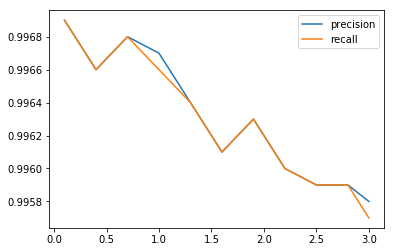

In [31]:
alpha = []
precision = []
recall = []
for a, x in RESULTS:
    _x = x.split()
    alpha.append(a)
    precision.append(_x[-4])
    recall.append(_x[-3])

print('Effect of increasing Alpha on precision and recall')

plt.plot(alpha, precision, label='precision')
plt.plot(alpha, recall, label='recall')
plt.legend()

# Thank you! 

## Extremely fun activity! :D

## Part 9: Tuning the vectorizer (Challenge)

Thus far, we have been using the default parameters of [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html):

However, the vectorizer is worth tuning, just like a model is worth tuning! Here are a few parameters that you might want to tune:

- **stop_words:** string {'english'}, list, or None (default)
    - If 'english', a built-in stop word list for English is used.
    - If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
    - If None, no stop words will be used.

- **ngram_range:** tuple (min_n, max_n), default=(1, 1)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
    - All values of n such that min_n <= n <= max_n will be used.

- **max_df:** float in range [0.0, 1.0] or int, default=1.0
    - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

- **min_df:** float in range [0.0, 1.0] or int, default=1
    - When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. (This value is also called "cut-off" in the literature.)
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

**Guidelines for tuning CountVectorizer:**

- Use your knowledge of the **problem** and the **text**, and your understanding of the **tuning parameters**, to help you decide what parameters to tune and how to tune them.

Tasks:
1. **Experiment**, and let the data tell you the best approach!
2. Try to reduce or increase the features and get a better score on the previous model. 
   * Score above a 99.5%? Tell us! :)

## Part 10: Tuning the Laplacian Correction Factor (Challenge)

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> class sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

> Parameters:	
alpha : float, optional (default=1.0)
Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

One of the parameters that we can tune in training a Multinomial Naive Bayes Classifier is the Laplacian Correction Factor.

Tasks:
1. Tweak the correction factor from 0-3 in increments of 0.1, 5, and 10, thus training multiple classifiers.
2. Plot the precision-recall curves for these classifiers to compare and contrast.